In [3]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
from ipywidgets import (
    IntSlider, FloatSlider, FloatText, Checkbox, Dropdown,
    HBox, VBox, Button, Output, interactive_output
)
from IPython.display import display, clear_output
from tabulate import tabulate
import os

%matplotlib widget

# -------------------------
# --- Gamma line database ---
# -------------------------
gamma_lines = {
    #238U Chain
    "Th-234": [{"Emin": 89, "Emax": 95, "E": 92.6, "Intensity": 4.1, "Eff": 0.000, "HalfLife_s": 2082240.00}],
    "Pa-234m": [{"Emin": 992, "Emax": 1011, "E": 1001, "Intensity": 0.84, "Eff": 0.000423, "HalfLife_s": 69.57}], #NO CHINESE DATA ON EFF, BUT OK
    "Ra-226": [{"Emin": 180, "Emax": 192, "E": 186.2, "Intensity": 3.57, "Eff": 0.0035,   
                "HalfLife_s": 50586832800.000}],
    "Bi-214": [
        {"Emin": 602, "Emax": 616, "E": 609.3, "Intensity": 46.1, "Eff": 0.0188,
         "HalfLife_s": 1194.000},
        {"Emin": 1115, "Emax": 1125, "E": 1120.3, "Intensity": 14.9, "Eff": 0.005,
         "HalfLife_s": 1194.000},
        {"Emin": 1758, "Emax": 1772, "E": 1764.5, "Intensity": 15.3, "Eff": 0.0048,
         "HalfLife_s": 1194.000},
    ],
    "Pb-214": [
        {"Emin": 287, "Emax": 303, "E": 295.2, "Intensity": 18.4, "Eff": 0.0132,
         "HalfLife_s": 1614.960},
        {"Emin": 342, "Emax": 360, "E": 351.9, "Intensity": 35.6, "Eff": 0.0238,
         "HalfLife_s": 1614.960},
    ],
    "Pb-210": [
        {"Emin": 42, "Emax": 50, "E": 46.5, "Intensity": 4.3, "Eff": 0.006,    # NO CHINESE DATA ON EFF, BUT OK
         "HalfLife_s": 703719449.800},
    ],
    #232Th Chain
    "Ac-228": [{"Emin": 333, "Emax": 343, "E": 338.3, "Intensity": 11.27, "Eff": 0.0083,
                "HalfLife_s": 22140.000},
               {"Emin": 906, "Emax": 916, "E": 911.2, "Intensity": 25.8, "Eff": 0.01,
                "HalfLife_s": 22140.000},
               {"Emin": 963, "Emax": 975, "E": 969, "Intensity": 15.8, "Eff": 0.0057,
                "HalfLife_s": 22140.000}
     ],
    "Pb-212": [
        {"Emin": 232, "Emax": 243, "E": 238.6, "Intensity": 43.6, "Eff": 0.0374,
         "HalfLife_s": 38304.000},
    ],
    "Bi-212": [
        {"Emin": 722, "Emax": 732, "E": 727.3, "Intensity": 6.7, "Eff": 0.003,
         "HalfLife_s": 3632.400},
    ],
     "Tl-208": [
        {"Emin": 578, "Emax": 588, "E": 583.2, "Intensity": 85.0, "Eff": 0.0129,
         "HalfLife_s": 183.480},
         {"Emin": 2590, "Emax": 2630, "E": 2614.5, "Intensity": 99.8, "Eff": 0.0063,
         "HalfLife_s": 183.480},
    ],
    #235U Chain
    "U-235": [
        {"Emin": 138, "Emax": 149, "E": 143.8, "Intensity": 10.9, "Eff": 0.0054,
         "HalfLife_s": 39458780270400000.000},
        {"Emin": 181, "Emax": 190, "E": 185.5, "Intensity": 57.2, "Eff": 0.05807, # NO CHINESE DATA ON EFF, BUT OKAY 
         "HalfLife_s": 39458780270400000.000},
         {"Emin": 200, "Emax": 210, "E": 205.3, "Intensity": 5.03, "Eff": 0.025,
         "HalfLife_s": 39458780270400000.000},
    ],
    # SINGLE ISOTOPES
     "K-40": [
        {"Emin": 1450, "Emax": 1470, "E": 1460.8, "Intensity": 10.7, "Eff": 0.0035,
         "HalfLife_s": 39458780270400000.000}   
    ],
    "Co-60": [
        {"Emin": 1165, "Emax": 1180, "E": 1173.2, "Intensity": 99.85, "Eff": 0.0312,
         "HalfLife_s": 166344192.00},
        {"Emin": 1326, "Emax": 1338, "E": 1332.5, "Intensity": 99.98, "Eff": 0.0297,
         "HalfLife_s": 166344192.00}, 
    ],
    "Cs-137": [
        {"Emin": 656, "Emax": 667, "E": 661.7, "Intensity": 85.1, "Eff": 0.041,
         "HalfLife_s": 949252608.00},   
     ],
}

# ------------------------------------
# --- Read data from qtree (TTree) ---
# ------------------------------------
def read_energy_spectrum(filename, treename="qtree", branch="DepositedEnergy", bins=3000):
    with uproot.open(filename) as f:
        tree = f[treename]
        energies = tree[branch].array(library="np")
    hist, edges = np.histogram(energies * 1000, bins=bins, range=(0, 3000))
    centers = 0.5 * (edges[:-1] + edges[1:])
    return centers, hist, edges


# --- Rebin utility ---
def rebin_histogram(x, y, factor):
    factor = int(factor)
    if factor <= 1:
        return x, y
    n = len(y) // factor
    y_rebinned = y[:n * factor].reshape(n, factor).sum(axis=1)
    x_rebinned = x[:n * factor].reshape(n, factor).mean(axis=1)
    return x_rebinned, y_rebinned


# --- Fit models ---
def gaussian_const(E, A, mu, sigma, B):
    return A * np.exp(-0.5 * ((E - mu) / sigma) ** 2) + B

def gaussian_exp(E, A, mu, sigma, B, k):
    return A * np.exp(-0.5 * ((E - mu) / sigma) ** 2) + B * np.exp(-k*E)


# --- Negative log-likelihood for Poisson ---
def poisson_nll(params, x, y, model_func):
    model = model_func(x, *params)
    model = np.clip(model, 1e-12, None)
    return -np.sum(y * np.log(model) - model)


# --- Chi-square ---
def chi2(y, yfit, yerr):
    valid = yerr > 0
    return np.sum(((y[valid] - yfit[valid]) / yerr[valid]) ** 2)


# ----------------------------------------------------
# --- Main interactive plotting and fitting function ---
# ----------------------------------------------------
def plot_root_spectrum(filename, treename="qtree", branch="DepositedEnergy"):
    x, y, edges = read_energy_spectrum(filename, treename, branch)

    print(f"✅ File loaded: {os.path.basename(filename)}")
    print(f"Entries: {np.sum(y)} counts")

    # --- Widgets ---
    rebin_slider = IntSlider(min=1, max=64, step=1, value=1, description="Rebin")
    log_checkbox = Checkbox(value=False, description="Log scale")
    hist_style_dropdown = Dropdown(
        options=["step (edges)", "bar (filled)", "line (center)"],
        value="step (edges)",
        description="Plot style:"
    )
    fit_method_dropdown = Dropdown(
        options=["Chi2 (curve_fit)", "Poisson MLE"],
        value="Chi2 (curve_fit)",
        description="Fit method:"
    )
    fit_button = Button(description="Fit Peaks", button_style="success")
    
    # Manual fit options
    manual_fit_dropdown = Dropdown(
        options=["Gaussian + constant", "Gaussian + exponential"],
        value="Gaussian + constant",
        description="Manual fit:"
    )
    manual_fit_method_dropdown = Dropdown(
        options=["Chi2 (curve_fit)", "Poisson MLE"],
        value="Chi2 (curve_fit)",
        description="Fit method:"
    )
    manual_fit_button = Button(description="Run Manual Fit", button_style="info")

    Emin_slider = FloatSlider(value=0, min=0, max=3000, step=3, description="Emin (keV)")
    Emax_slider = FloatSlider(value=3000, min=0, max=3000, step=3, description="Emax (keV)")
    Emin_text = FloatText(value=Emin_slider.value, description="Emin:")
    Emax_text = FloatText(value=Emax_slider.value, description="Emax:")

    # Sync sliders ↔ text boxes
    def sync_widgets(slider, text):
        def on_slider_change(change): text.value = change['new']
        def on_text_change(change): slider.value = change['new']
        slider.observe(on_slider_change, names='value')
        text.observe(on_text_change, names='value')
    sync_widgets(Emin_slider, Emin_text)
    sync_widgets(Emax_slider, Emax_text)

    fig, ax = plt.subplots(figsize=(10, 6))
    output_area = Output()
    fit_output = Output()
    manual_fit_output = Output()
    spike_output = Output()

    # --- Spectrum plotting ---
    def plot_spectrum(rebin_factor, log_scale, Emin, Emax, hist_style):
        with output_area:
            clear_output(wait=True)
            ax.clear()
            x_reb, y_reb = rebin_histogram(x, y, rebin_factor)
            y_err = np.sqrt(np.maximum(y_reb, 1))

            if hist_style == "step (edges)":
                ax.step(edges[:-1], y, where="post", color="black", lw=1,
                        label=f"{os.path.basename(filename)} (rebin={rebin_factor})")
            elif hist_style == "bar (filled)":
                ax.bar(x_reb, y_reb, width=np.diff(edges).mean(), align='center',
                       color='gray', edgecolor='black', alpha=0.7,
                       label=f"{os.path.basename(filename)} (rebin={rebin_factor})")
            else:
                ax.plot(x_reb, y_reb, lw=1, color="black",
                        label=f"{os.path.basename(filename)} (rebin={rebin_factor})")

            ax.set_xlabel("Energy (keV)")
            ax.set_ylabel("Counts")
            ax.set_title(f"Spectrum from {os.path.basename(filename)}")
            ax.grid(True)
            if log_scale:
                ax.set_yscale("log")

            # Highlight ROI
            ax.axvspan(Emin, Emax, color='orange', alpha=0.3,
                       label=f"ROI: {Emin:.0f}-{Emax:.0f} keV")
            mask = (x_reb >= Emin) & (x_reb <= Emax)
            counts_in_region = np.sum(y_reb[mask])
            print(f"ROI: {Emin:.1f} – {Emax:.1f} keV")
            print(f"Total counts in region: {counts_in_region:.0f}\n")

            # Annotate gamma lines
            print("📊 Gamma Line Integration (pre-fit):")
            colors = plt.cm.tab10.colors
            color_index = 0
            for isotope, lines in gamma_lines.items():
                print(f"\n→ {isotope}")
                for line in lines:
                    Emin_fit, Emax_fit = line["Emin"], line["Emax"]
                    print(f"  {line['E']:.1f} keV | Range: {Emin_fit}-{Emax_fit} keV | Intensity: {line['Intensity']}%")
                    ax.axvspan(Emin_fit, Emax_fit, color=colors[color_index % len(colors)], alpha=0.2)
                    ax.axvline(line["E"], color=colors[color_index % len(colors)], linestyle="--", alpha=0.6)
                    ax.text(line["E"], np.max(y_reb) * 0.9, f"{isotope}",
                            rotation=90, va='bottom', ha='center', fontsize=8,
                            color=colors[color_index % len(colors)])
                    color_index += 1

            ax.legend()
            fig.canvas.draw()
        return x_reb, y_reb, y_err

    # Initial plot
    x_reb, y_reb, y_err = plot_spectrum(rebin_slider.value, log_checkbox.value,
                                        Emin_slider.value, Emax_slider.value, hist_style_dropdown.value)

    # --- Original fit callback ---
    def fit_peaks_callback(_):
        with fit_output:
            clear_output(wait=True)
            print(f"\n📈 Fit Results Summary ({fit_method_dropdown.value}):\n")
            colors = plt.cm.tab10.colors
            color_index = 0

            for isotope, lines in gamma_lines.items():
                table_data = []
                for line in lines:
                    Emin_fit, Emax_fit = line["Emin"], line["Emax"]
                    mask_line = (x_reb >= Emin_fit) & (x_reb <= Emax_fit)
                    x_fit, y_fit, yerr_fit = x_reb[mask_line], y_reb[mask_line], y_err[mask_line]
                    if len(x_fit) < 5:
                        continue

                    try:
                        p0 = [max(y_fit), line["E"], 3, max(y_fit)/2, 1e-3]
                        bounds = ([0, -np.inf, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])

                        if fit_method_dropdown.value == "Chi2 (curve_fit)":
                            popt, pcov = curve_fit(gaussian_const, x_fit, y_fit, p0=p0[:4],
                                                   sigma=yerr_fit, absolute_sigma=True)
                            perr = np.sqrt(np.diag(pcov))
                            yfit = gaussian_const(x_fit, *popt)
                            ndf = len(y_fit) - len(popt)
                            red_chi2 = chi2(y_fit, yfit, yerr_fit)/ndf if ndf > 0 else np.nan
                        else:
                            result = minimize(poisson_nll, p0[:4], args=(x_fit, y_fit, gaussian_const),
                                              bounds=[(0, np.inf),(min(x_fit), max(x_fit)),(0,np.inf),(0,np.inf)], method='L-BFGS-B')
                            popt = result.x
                            perr = np.full_like(popt, np.nan)
                            yfit = gaussian_const(x_fit, *popt)
                            ndf = len(y_fit) - len(popt)
                            red_chi2 = chi2(y_fit, yfit, yerr_fit)/ndf if ndf > 0 else np.nan

                        A, mu, sigma, B = popt
                        area_counts = A * sigma * np.sqrt(2 * np.pi)
                        table_data.append([
                            f"{line['E']:.1f}",
                            f"{mu:.2f} ± {perr[1]:.2f}",
                            f"{sigma:.2f} ± {perr[2]:.2f}",
                            f"{area_counts:.1f}",
                            f"{B:.2e}",
                            f"{red_chi2:.4f}"
                        ])

                        x_dense = np.linspace(Emin_fit, Emax_fit, 200)
                        ax.plot(x_dense, gaussian_const(x_dense, *popt),
                                color=colors[color_index % len(colors)], lw=1.5)

                    except Exception as e:
                        table_data.append([f"{line['E']:.1f}"]*6)

                    color_index += 1

                if table_data:
                    headers = ["E (keV)", "μ (keV)", "σ (keV)", "Area (counts)", "B", "χ²/ndf"]
                    print(f"\n→ {isotope}")
                    print(tabulate(table_data, headers=headers, tablefmt="grid"))

            fig.canvas.draw()

    fit_button.on_click(fit_peaks_callback)

    # --- Manual fit callback ---
    def manual_fit_callback(_):
        with manual_fit_output:
            clear_output(wait=True)
            print(f"\n📈 Manual Fit ({manual_fit_dropdown.value}, {manual_fit_method_dropdown.value})\n")
            colors = plt.cm.tab10.colors
            x_reb, y_reb, y_err = rebin_histogram(x, y, rebin_slider.value), np.sqrt(np.maximum(y,1))
            
            # Use ROI sliders
            Emin_fit, Emax_fit = Emin_slider.value, Emax_slider.value
            mask = (x_reb >= Emin_fit) & (x_reb <= Emax_fit)
            x_fit, y_fit, yerr_fit = x_reb[mask], y_reb[mask], y_err[mask]
            if len(x_fit) < 5:
                print("Not enough points for manual fit in selected ROI")
                return
            
            if manual_fit_dropdown.value == "Gaussian + constant":
                model_func = gaussian_const
                p0 = [max(y_fit), x_fit[np.argmax(y_fit)], 3, max(y_fit)/2]
            else:
                model_func = gaussian_exp
                p0 = [max(y_fit), x_fit[np.argmax(y_fit)], 3, max(y_fit)/2, 1e-3]

            try:
                if manual_fit_method_dropdown.value == "Chi2 (curve_fit)":
                    popt, pcov = curve_fit(model_func, x_fit, y_fit, p0=p0,
                                           sigma=yerr_fit, absolute_sigma=True, maxfev=5000)
                    perr = np.sqrt(np.diag(pcov))
                else:
                    result = minimize(poisson_nll, p0, args=(x_fit, y_fit, model_func),
                                      method='L-BFGS-B')
                    popt = result.x
                    perr = np.full_like(popt, np.nan)

                print("Fit parameters:")
                for i, val in enumerate(popt):
                    err = perr[i] if not np.isnan(perr[i]) else 0
                    print(f"p{i} = {val:.3f} ± {err:.3f}")

                x_dense = np.linspace(Emin_fit, Emax_fit, 200)
                ax.plot(x_dense, model_func(x_dense, *popt), color='red', lw=2)
                fig.canvas.draw()

            except Exception as e:
                print("Manual fit failed:", e)

    manual_fit_button.on_click(manual_fit_callback)

    # --- Spike detection callback ---
    def spike_detection_callback(_):
        with spike_output:
            clear_output(wait=True)
            x_reb, y_reb = rebin_histogram(x, y, rebin_slider.value)
            detected_bins = []
            for i in range(5, len(y_reb)-5):
                neighbors = np.concatenate([y_reb[i-5:i], y_reb[i+1:i+6]])
                if y_reb[i] >= 25 * np.sqrt(np.mean(neighbors)):
                    detected_bins.append((i, x_reb[i], y_reb[i]))
            if detected_bins:
                print("Gamma line detected (bin idx, energy, counts):")
                for isotope, lines in gamma_lines.items():
                           for line in lines:
                               for idx, energy, counts in detected_bins:
                                   if energy <= line["E"] + 0.5 and energy >= line["E"] - 0.5 :
                                      eff = counts * 100 / (1e6)
                                      print(f"{isotope} -> {idx}: {energy:.1f} keV, counts={counts}: Efficiency = {eff:.3f} % ") 
            else:
                print("No significant spikes detected.")

    spike_button = Button(description="Look for peaks", button_style="warning")
    spike_button.on_click(spike_detection_callback)

    # --- Plot update ---
    def update_plot(rebin_factor, log_scale, Emin, Emax, hist_style):
        nonlocal x_reb, y_reb, y_err
        x_reb, y_reb, y_err = plot_spectrum(rebin_factor, log_scale, Emin, Emax, hist_style)

    controls = VBox([
        HBox([rebin_slider, log_checkbox, hist_style_dropdown, fit_method_dropdown, fit_button]),
        HBox([manual_fit_dropdown, manual_fit_method_dropdown, manual_fit_button]),
        HBox([spike_button]),
        HBox([Emin_slider, Emax_slider]),
        HBox([Emin_text, Emax_text]),
        output_area,
        fit_output,
        manual_fit_output,
        spike_output
    ])

    out = interactive_output(update_plot, {
        'rebin_factor': rebin_slider,
        'log_scale': log_checkbox,
        'Emin': Emin_slider,
        'Emax': Emax_slider,
        'hist_style': hist_style_dropdown
    })

    display(controls, out)



✅ File loaded: HPGe_CJPL_PandaX_Li2CO3_238U.root
Entries: 366909 counts


Output()

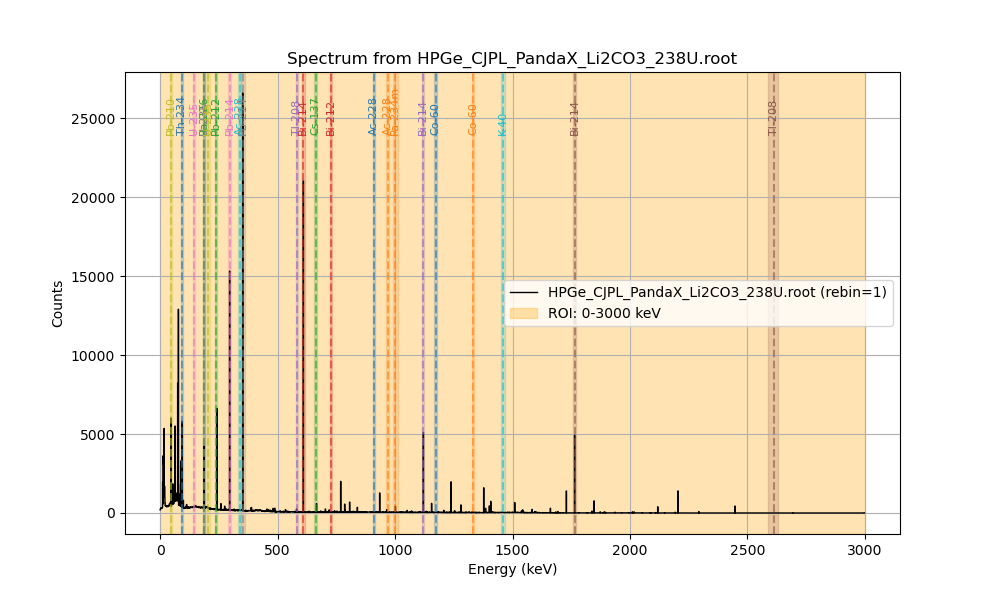

In [4]:
# --- Example usage ---

plot_root_spectrum(    "/home/brada/Desktop/Radiopurity Spurious Data/Chinese Data/Li2CO3-Simulations/Li2CO3/HPGe_CJPL_PandaX_Li2CO3_238U.root",    "qtree")





✅ File loaded: HPGe_CJPL_PandaX_Li2CO3_235.root
Entries: 595188 counts


Output()

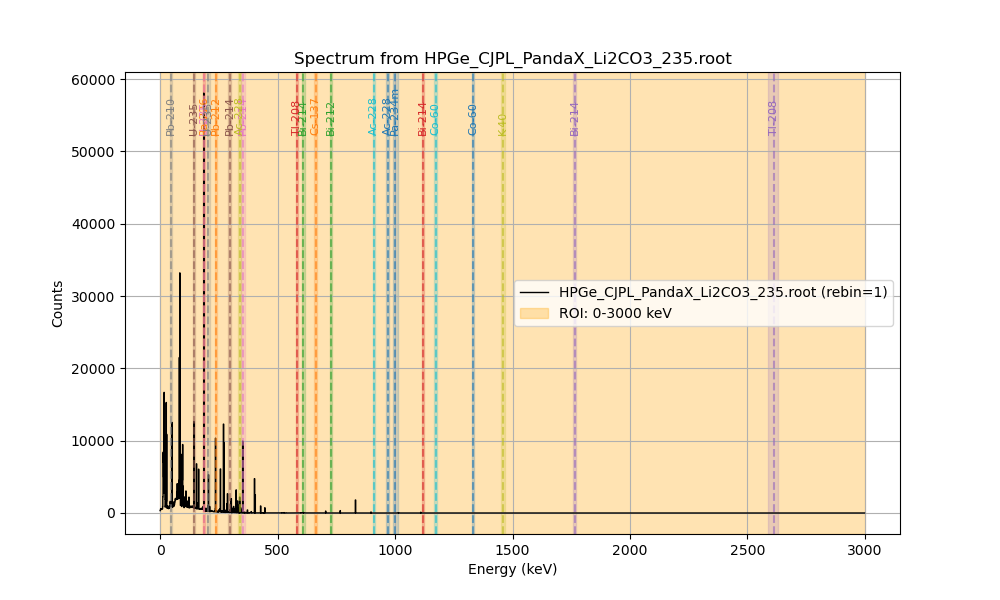

In [2]:
plot_root_spectrum("/home/brada/Desktop/Radiopurity Spurious Data/Chinese Data/Li2CO3-Simulations/Li2CO3/HPGe_CJPL_PandaX_Li2CO3_235.root","qtree")

✅ File loaded: HPGe_CJPL_PandaX_Li2CO3_232Th.root
Entries: 372900 counts


Output()

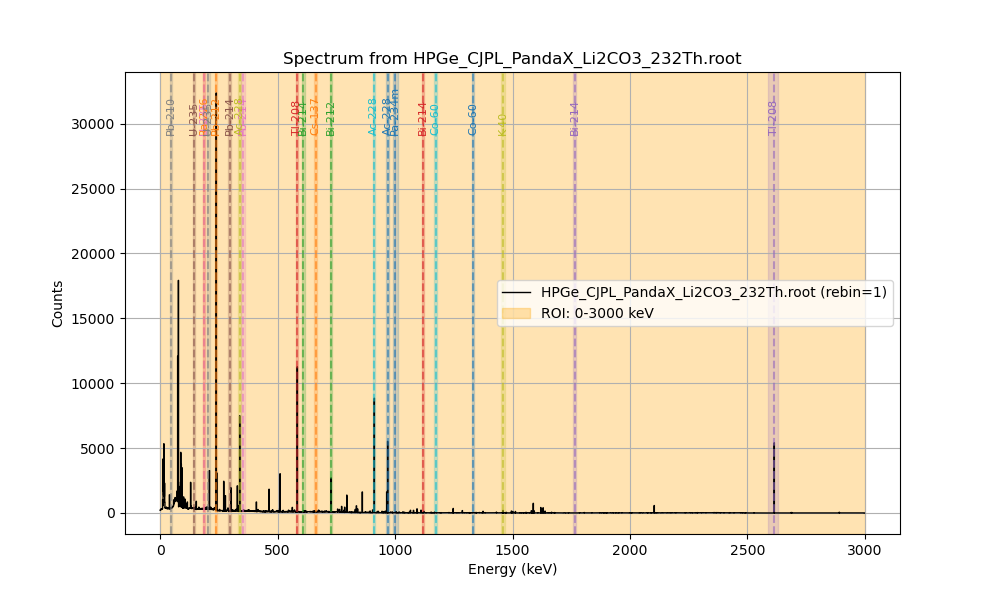

In [2]:
# --- Example usage ---
plot_root_spectrum(
    "/home/brada/Desktop/Radiopurity Spurious Data/Chinese Data/Li2CO3-Simulations/Li2CO3/HPGe_CJPL_PandaX_Li2CO3_232Th.root",
    "qtree"
)


✅ File loaded: HPGe_CJPL_PandaX_Li2CO3_40K.root
Entries: 17803 counts


Output()

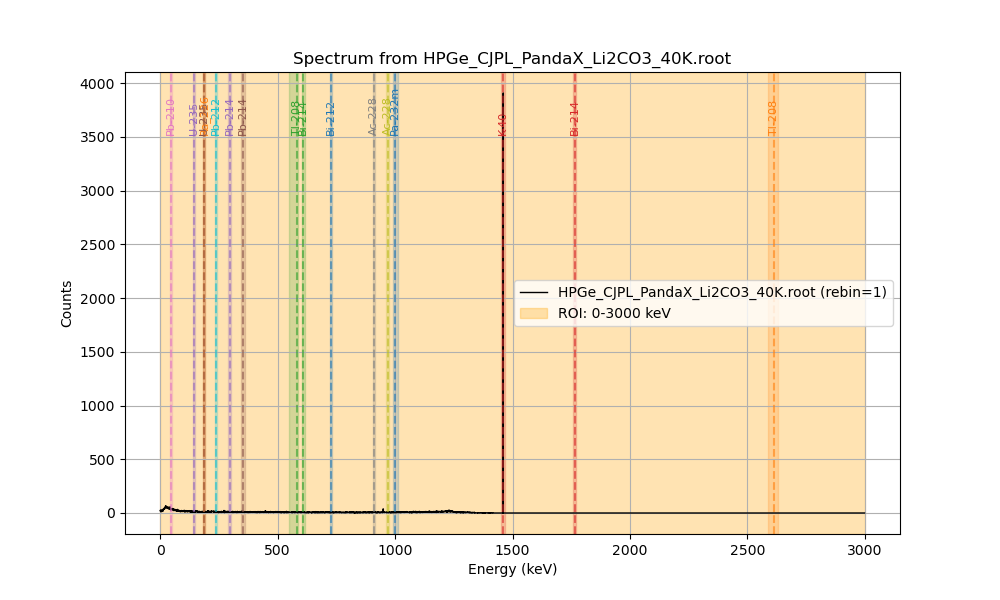

In [7]:
# --- Example usage ---
plot_root_spectrum(
    "/home/brada/Desktop/Radiopurity Spurious Data/Chinese Data/Li2CO3-Simulations/Li2CO3/HPGe_CJPL_PandaX_Li2CO3_40K.root",
    "qtree"
)
